# Data Collection

Import the datasets and combine the datasets into a single dataframe

In [1]:
# Import the necessary library
import pandas as pd

# Load the datasets
kejriwal_data = pd.read_csv("../Datasets/Arvind Kejriwal_data.csv")
modi_data = pd.read_csv("../Datasets/Narendra Modi_data.csv")
gandhi_data = pd.read_csv("../Datasets/Rahul Gandhi_data.csv")

# Combine the datasets into a single dataframe
combined_data = pd.concat([kejriwal_data, modi_data, gandhi_data], ignore_index=True)

# Display the first few rows of the combined dataset to verify
combined_data.head()


,Date,User,Tweet,Time
0,2022:10:19,bhoo_sene,@TajinderBagga Aap leaders are speaking agains...,23:47:01
1,2022:10:19,Madhusu88858324,Bjp Aap se sikh rhi h\nNarendra Modi Manish Si...,23:06:35
2,2022:10:19,PremshilaKumarp,@JaikyYadav16 Arvind kejriwal,22:56:42
3,2022:10:19,lifebecom,Arvind Kejriwal As PM Visits Gujarat School ht...,22:20:51
4,2022:10:19,sphavisha,Arvind Kejriwal's stand against rape is very c...,22:20:16


### Cleaning

Define the cleaning function to retain exclamatory marks (!) and question marks (?)
Convert to lowercase for uniformity (but note that this won't impact non-Latin scripts)
After that, execute it

In [2]:
# Define the cleaning function to retain exclamatory marks (!) and question marks (?)
def clean_tweet_retain_special(tweet):
    # Remove URLs
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)
    # Remove user mentions (@)
    tweet = re.sub(r'\@\w+', '', tweet)
    tweet = re.sub(r'\s+[a-zA-Z]\s+', ' ', tweet)
    tweet = re.sub(r'\^[a-zA-Z]\s+', ' ', tweet) 
    tweet = re.sub(r'\s+', ' ', tweet, flags=re.I)
    tweet = re.sub(r'^b\s+', '', tweet)
    # Convert to lowercase for uniformity (but note that this won't impact non-Latin scripts)
    tweet = tweet.lower()
    return tweet


In [3]:
import re

# Clean the tweets in the dataset without removing exclamatory marks and question marks
combined_data['Cleaned_Tweet'] = combined_data['Tweet'].apply(clean_tweet_retain_special)

# Remove duplicates based on the cleaned tweets
combined_data.drop_duplicates(subset=['Cleaned_Tweet'], keep='first', inplace=True)

# Display the first few rows after cleaning
combined_data[['Tweet', 'Cleaned_Tweet']].head()

,Tweet,Cleaned_Tweet
0,@TajinderBagga Aap leaders are speaking agains...,aap leaders are speaking against hindu gods. ...
1,Bjp Aap se sikh rhi h\nNarendra Modi Manish Si...,bjp aap se sikh rhi narendra modi manish sisod...
2,@JaikyYadav16 Arvind kejriwal,arvind kejriwal
3,Arvind Kejriwal As PM Visits Gujarat School ht...,arvind kejriwal as pm visits gujarat school
4,Arvind Kejriwal's stand against rape is very c...,arvind kejriwal's stand against rape is very c...


### Dataset Analysis

Lets analyse the most used words in the dataset to get a better understanding

In [4]:
import nltk
import matplotlib.pyplot as plt
from collections import Counter

# Tokenization using space-based split
combined_data['Tokens'] = combined_data['Cleaned_Tweet'].str.split()

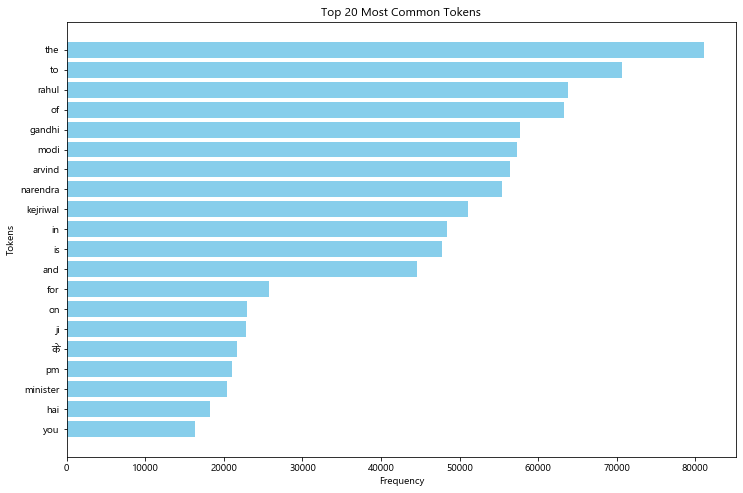

In [5]:
# Set Matplotlib to use 'Nirmala UI' font
plt.rcParams['font.family'] = 'Nirmala UI'

# Flatten the list of tokens and calculate frequency
all_tokens = [token for sublist in combined_data['Tokens'].tolist() for token in sublist]
token_frequency = Counter(all_tokens)

# Plot the most common tokens
common_tokens = token_frequency.most_common(20)
tokens, counts = zip(*common_tokens)

plt.figure(figsize=(12, 8))
plt.barh(tokens, counts, color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Tokens')
plt.title('Top 20 Most Common Tokens')
plt.gca().invert_yaxis()  # Display the most frequent token at the top
plt.show()


# Sample Dataset Creation

We will create a sample dataset of 100 tweets containing 20 telugu and 20 hindi tweets and we will manually label their sentiments

In [6]:
# Step 1: Define a list of keywords related to Indian politics
keywords = ['politics', 'election', 'minister', 'government', 'party', 'leader', 
            'vote', 'bjp', 'congress', 'aap', 'rajya sabha', 'lok sabha', 'mp', 
            'mla', 'assembly', 'parliament', 'campaign', 'candidate', 'chief minister', 'pm']

# Step 2: Filter tweets related to Indian politics based on keywords
politics_tweets = combined_data[combined_data['Cleaned_Tweet'].str.contains('|'.join(keywords), case=False)]

In [7]:
import random

# Assuming politics_tweets contains tweets related to Indian politics

# Filter tweets based on the presence of common English, Hindi, and Telugu words or characters
english_tweets = politics_tweets[politics_tweets['Tweet'].str.contains(r'\b(the|and|is|of|to|in|that|it|for)\b', case=False, na=False)]
hindi_tweets = politics_tweets[politics_tweets['Tweet'].str.contains(r'[\u0900-\u097F]', na=False)]  # Unicode range for Devanagari script
telugu_tweets = politics_tweets[politics_tweets['Tweet'].str.contains(r'[\u0C00-\u0C7F]', na=False)]  # Unicode range for Telugu script

# Randomly sample the specified number of tweets for each language
sample_english_tweets = english_tweets.sample(n=60, random_state=42)
sample_hindi_tweets = hindi_tweets.sample(n=20, random_state=42)
sample_telugu_tweets = telugu_tweets.sample(n=20, random_state=42)

# Combine the samples into a single dataset
final_sample_tweets = pd.concat([sample_english_tweets, sample_hindi_tweets, sample_telugu_tweets])

# Remove these tweets from the main dataset to avoid duplication
combined_data = combined_data.drop(final_sample_tweets.index)


C:\Users\harsh\AppData\Local\Temp/ipykernel_14932/2048470955.py:6: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  english_tweets = politics_tweets[politics_tweets['Tweet'].str.contains(r'\b(the|and|is|of|to|in|that|it|for)\b', case=False, na=False)]


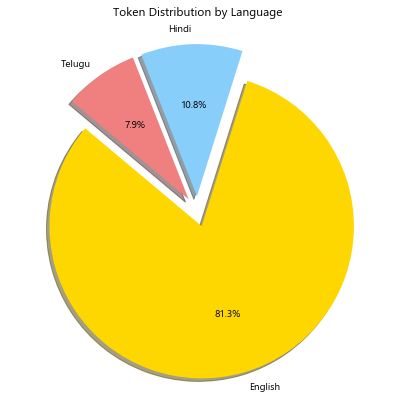

In [8]:
import matplotlib.pyplot as plt

# Tokenize the tweets
final_sample_tweets['Tokens'] = final_sample_tweets['Tweet'].str.split()

# Flatten the list of tokens
all_tokens = [token for sublist in final_sample_tweets['Tokens'].tolist() for token in sublist]

# Classify each token by language
def classify_language(token):
    if any('\u0900' <= char <= '\u097F' for char in token):  # Unicode range for Devanagari script
        return 'Hindi'
    elif any('\u0C00' <= char <= '\u0C7F' for char in token):  # Unicode range for Telugu script
        return 'Telugu'
    else:
        return 'English'

languages = [classify_language(token) for token in all_tokens]
language_counts = Counter(languages)

# Plot a pie chart
labels = language_counts.keys()
sizes = language_counts.values()
colors = ['gold', 'lightskyblue', 'lightcoral']
explode = (0.1, 0.1, 0.1)  # explode 1st slice for visibility

plt.figure(figsize=(10, 7))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title("Token Distribution by Language")
plt.show()


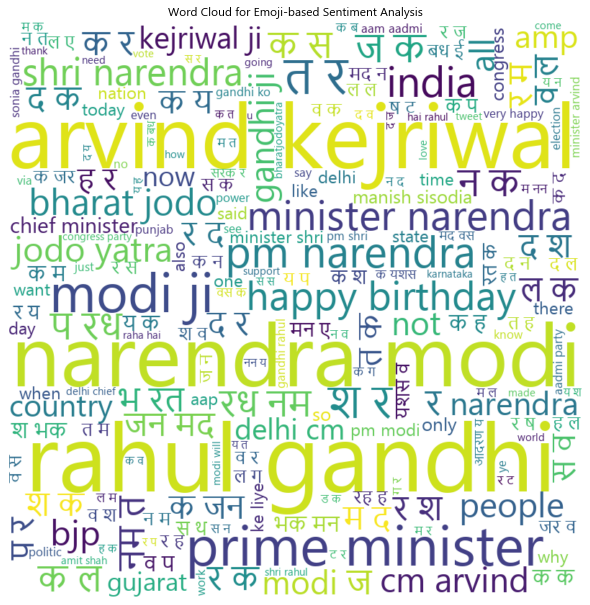

In [9]:
from wordcloud import WordCloud
stopwords = set([
    "i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", 
    "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", 
    "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", 
    "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", 
    "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", 
    "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", 
    "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", 
    "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", 
    "then", "once"
])


# Combine all tweets into a single text
text = ' '.join(combined_data['Cleaned_Tweet'])
# Generate word cloud without specifying any font
wordcloud = WordCloud(width=800, height=800, 
                background_color='white', 
                stopwords=stopwords, 
                font_path='../Font/Nirmala.ttf',
                min_font_size=10).generate(text)

# Plot the word cloud
plt.figure(figsize=(8, 8), facecolor=None) 
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis("off") 
plt.tight_layout(pad=0) 
plt.title('Word Cloud for Emoji-based Sentiment Analysis')
plt.show()

Store the sample dataset into a separate file "sample_tweets.csv", we will then manually classify them into positive , negative and neutral.

In [10]:
# Writing the final_sample_tweets dataframe to a CSV file
file_path = "../Temp/sample_tweets.csv"
final_sample_tweets.to_csv(file_path, index=False)